#Colorazione dei grafi con una Physics-Inspired Graph Neural Networks(SAGE)



Link cartella condivisa github: https://github.com/FedericaDibba/GraphColoring_DiBartolomeo_Pozzi_Ripani

##Imports

Import e definizione di funzioni e classi



In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)
import os.path

2.5.0+cu121
0.20.0+cu121


In [2]:
import random
import torch
import warnings
import numpy as np
import networkx as nx
import os
import torch.nn as nn
import torch.nn.functional as F


from time import time

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
try:
    import torch_geometric
except ImportError:
    !pip install torch_geometric
    import torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00


In [5]:
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GCNConv
from itertools import chain
from torch_geometric.utils import from_networkx

In [6]:
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cpu



In [7]:
# Set del seme iniziale
SEED_VALUE = 0
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)

In [8]:
# Settare GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

print(TORCH_DEVICE)

Will use device: cpu, torch dtype: torch.float32
cpu


In [23]:
# Inserire percorso Drive della cartella
os.chdir('/content/drive/MyDrive')

In [24]:
ls

1000link_NEW_30semi_myciel6_errore.pth  grafo_500_NEW.gml
1500link_NEW_30semi_myciel6_errore.pth  instances.tar
500link_NEW_30semi_myciel6_errore.pth   Myciel6_1000link.pth
data/                                   __pycache__/
gc_example.ipynb                        requirements.txt
gc_example_prova1.ipynb                 SAGE_best_model_coloring_11X11.pth
GCN_best_model_coloring_5X5.pth         SAGE_best_model_coloring_13X13.pth
grafo_0.gml                             SAGE_best_model_coloring_5X5.pth
grafo_0_NEW.gml                         SAGE_best_model_coloring_6X6.pth
grafo_1000.gml                          SAGE_best_model_coloring_7X7
grafo_1000_NEW.gml                      SAGE_best_model_coloring_7X7.pth
grafo_1500_NEW.gml                      SAGE_best_model_coloring_8X12.pth
grafo_2000.gml                          SAGE_best_model_coloring_9X9.pth
grafo_2000_NEW.gml                      SAGE_best_model_coloring_anna.pth
grafo_2500_NEW.gml                      SAGE_best_model_co

In [25]:
# Dizionario delle colorazioni del grafo che vogliamo usare
chromatic_numbers = {
    # COLOR graphs
    'jean.col': 10,
    'anna.col': 11,
    'huck.col': 11,
    'david.col': 11,
    'homer.col': 13,
    'myciel5.col': 6,
    'myciel6.col': 7,
    'queen5_5.col': 5,
    'queen6_6.col': 7,
    'queen7_7.col': 7,
    'queen8_8.col': 9,
    'queen9_9.col': 10,
    'queen8_12.col': 12,
    'queen11_11.col': 11,
    'queen13_13.col': 13,
    # Citations graphs
    'cora.cites': 5,
    'citeseer.cites': 6,
    'pubmed.cites': 8
}

In [13]:
def set_seed(seed):
    """
    Imposta un seed random dal seed che è passato come argomento.

    :param seed: Numero intero usato come seed
    :type seed: int
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [14]:
def get_adjacency_matrix(nx_graph, torch_device, torch_dtype):
    """
    Pre-carica matrice di adiacenza, la restituisce in formato torch

    :param nx_graph: Grafo in oggetto da cui prendere matrice di adiacenza
    :type nx_graph: networkx.Graph
    :param torch_device: Dispositivo in cui si vuole trasferire la matrice di adiacenza (CPU vs GPU)
    :type torch_device: str
    :param torch_dtype: Specifica il datatype di pytorch da usare per la matrice di adiacenza (32bit vs 64bit)
    :type torch_dtype: str
    :return: Matrice di adiacenza del grafo in formato torch
    :rtype: torch.tensor
    """

    adj = nx.linalg.graphmatrix.adjacency_matrix(nx_graph).todense() # Costruisce matrice di adiacenza a partire dal grafo in argomento
    adj_ = torch.tensor(adj).type(torch_dtype).to(torch_device) # Converte adj in formato torch

    return adj_

In [15]:
def parse_line(file_line, node_offset):
    """
    Funzione che analizza una riga del file dei colori e restituisce i nodi connessi.
    Salta il primo elemento, che rappresenterebbe la definizione di edge "e".

    :param file_line: Riga da analizzare, il formato è (e, x, y), dove "e" indica edge, mentre x e y indicano i nodi connessi
    :type file_line: str
    :param node_offset: Valore intero che serve per compensare l'indicizzazione dei nodi
    :type node_offset: int
    :return: Nodi connessi dagli edges definiti nella linea passata come argomento
    :rtype: int, int
    """

    # Salta la prima colonna
    x, y = file_line.split(' ')[1:]

    # I nodi del file in argomento sono numerati dall'1 all'n, mentre python lavora dallo 0 all'n-1
    x, y = int(x)+node_offset, int(y)+node_offset

    return x, y

In [16]:
# Costruzione del grafo a partire dal problema che gli imponiamo
def build_graph_from_color_file(fname, node_offset=-1, parent_fpath=''):
    """
    Carica la definizione del problema (grafo) dal COLOR file (per esempio xxx.col).

    :param fname: Filename del file COLOR
    :type fname: str
    :param node_offset: Valore intero che serve per compensare l'indicizzazione dei nodi
    :type node_offset: int
    :param parent_fpath: Percorso che serve per individuare la posizione del file
    :type parent_fpath: str
    :return: Grafo costruito a partire dalla definizione del problema nel file COLOR
    :rtype: networkx.Graph
    """
    # Costruisco il percorso completo del file e lo stampo
    fpath = os.path.join(parent_fpath, fname)

    print(f'Building graph from contents of file: {fpath}')
    with open(fpath, 'r') as f:
        content = f.read().strip()

    # Lettura del contenuto del file COLOR, tiene conto del fatto che contenga prima
    # alcune righe descrittive che iniziano con "c" o "p" (commenti o dichiarazioni del problema).
    # Identifica l'inizio della definizione vera e propria del problema cercando la prima riga
    # che inizia con "p". Dopo questa riga, considera i dati come la definizione del grafo.

    start_idx = [idx for idx, line in enumerate(content.split('\n')) if line.startswith('p')][0]
    lines = content.split('\n')[start_idx:]

    # Estrazione informazioni sugli edges li salva su un grafo temporaneo
    edges = [parse_line(line, node_offset) for line in lines[1:] if len(line) > 0]
    nx_temp = nx.from_edgelist(edges)

    # Creazione del grafo indiretto con nodi ed edges presi dal grafo temporaneo
    nx_graph = nx.Graph()    # Grafo indiretto
    nx_graph.add_nodes_from(sorted(nx_temp.nodes()))
    nx_graph.add_edges_from(nx_temp.edges)

    return nx_graph

In [17]:
# Calcolo errore come: numero di edges sbagliate con potts/num link
def err_train(cost_discreto,num_link_torch):
  """
    Calcolo errore del train

    :param cost_discreto: Costo discreto associato al grafo
    :type cost_discreto: int
    :param num_link_torch: Numero di link del grafo
    :type num_link_torch: int
    :return: Errore generalizzato
    :rtype: float
  """
  num_vero_link = num_link_torch * 0.5  # Moltiplico per 0.5 perchè PyTorch conta gli edge 2 volte perchè il grafo è indiretto
  eps = cost_discreto / num_vero_link

  return eps

In [18]:
# Calcolo della loss continua
def loss_func_mod(probs, adj_tensor):
    """
    Function to compute cost value based on soft assignments (probabilities)

    :param probs: Probability vector, of each node belonging to each class
    :type probs: torch.tensor
    :param adj_tensor: Adjacency matrix, containing internode weights
    :type adj_tensor: torch.tensor
    :return: Loss, given the current soft assignments (probabilities)
    :rtype: float
    """

    # Sarebbe il prodotto fra le coppie di vettori probabilitá di nodi collegati (Aij=1) e diviso per due per simmetria
    loss_ = torch.mul(adj_tensor, (probs @ probs.T)).sum() / 2

    return loss_

# Calcolo della loss discreta (numero di link sbagliati per una certa colorazione)
def loss_func_color_hard(coloring, nx_graph):
    """
    Function to compute cost value based on color vector (0, 2, 1, 4, 1, ...)

    :param coloring: Vector of class assignments (colors)
    :type coloring: torch.tensor
    :param nx_graph: Graph to evaluate classifications on
    :type nx_graph: networkx.Graph
    :return: Cost of provided class assignments
    :rtype: torch.tensor
    """

    cost_ = 0
    for (u, v) in nx_graph.edges:
        cost_ += 1*(coloring[u] == coloring[v])*(u != v)     # Controlla se due nodi collegati hanno lo stesso colore e sono diversi


    return cost_


# Problema 1 - Statistica queen9_9

Analisi della statistica del costo discreto dopo il train della rete neurale SAGE applicata al grafo `queen9_9`

## Passo 1 - Set iperparameters - Impostazione del problema queen9_9

Stiamo fornendo un set di iperparametri del modello. Si possono modificare al variare del problema che si vuole analizzare.


Includiamo anche dei parametri che permettono di uscire dal train al raggiungimento di determinate soglie di pazienza (`patience`) che conta il numero di volte consecutive in cui la loss i-esima non cambia la loss (i - 1)-esima del valore della tolleranza (`tolerance`).
Definisce anche il tipo aggregazione fra i primi vicini (`layer_agg_type`) in GraphSAGE, e tiene conto del tipo di problema che vogliamo risolvere (nome del problema, numero di colori).

In [26]:
# Specifica quì il problema da risolvere e il percorso dove trovare il dataset:
problem_file = 'queen9_9.col'
input_parent = './data/input/COLOR/instances'

In [27]:
# Inserire iperparametri (presi dal paper di riferimento)
hypers = {
        'model': 'SAGEConv',        # Useró solo SAGEConv come layer convoluzionale
        'dim_embedding': 109,       # Numero di features iniziali associate ad ogni nodo
        'dropout': 0.3257,
        'learning_rate': 0.02636,
        'hidden_dim': 16,           # Dimensione del layer nascosto (in questo algoritmo un solo hidden layer-> vedi class GraphSAGE)
        'seed': SEED_VALUE,
    }


# Inserire parametri del train
solver_hypers = {
    'tolerance': 1e-3 ,                                 # Se la loss non cambia piú della tolleranza, aggiungo +1 al conto di 'patience'
    'number_epochs': int(1e4),                          # Numero massimo di step del training
    'patience': 500,                                    # Numero di volte di seguito nel quale la loss non cambia necessari per arrestare il run prematuramente
    'graph_file': problem_file,                         # Indica quale problema stiamo risolvendo
    'layer_agg_type': 'mean',                           # Indica come i vicini aggregati sono stati campionati all'interno di graphSAGE
    'number_classes': chromatic_numbers[problem_file]   # Numero di colori per risolvere il grafo
}

# Crea un dizionario con iperparametri
hypers.update(solver_hypers)

## Passo 2 - Caricamento del problema e creazione del grafo

Caricamento del problema dal percorso specificato. Le variabili `input_parent` e `problem_file` sono specificate sopra e corrispondono rispettivamente al percorso della cartella e al nome del file.

In [28]:
# Stabilire percorso del file
input_fpath = os.path.join(input_parent, problem_file)

# Caricamento del grafo
nx_graph = build_graph_from_color_file(input_fpath, node_offset=-1, parent_fpath='')

# Conversione dal formato network al formato Torch e trasferimento sul dispositivo utilizzato
torchgeom_graph = from_networkx(nx_graph)
torchgeom_graph = torchgeom_graph.to(TORCH_DEVICE)

Building graph from contents of file: ./data/input/COLOR/instances/queen9_9.col


In [29]:
# Caratteristiche grafo
print('torchgeom_graf=',torchgeom_graph)

torchgeom_graf= Data(edge_index=[2, 2112], num_nodes=81)


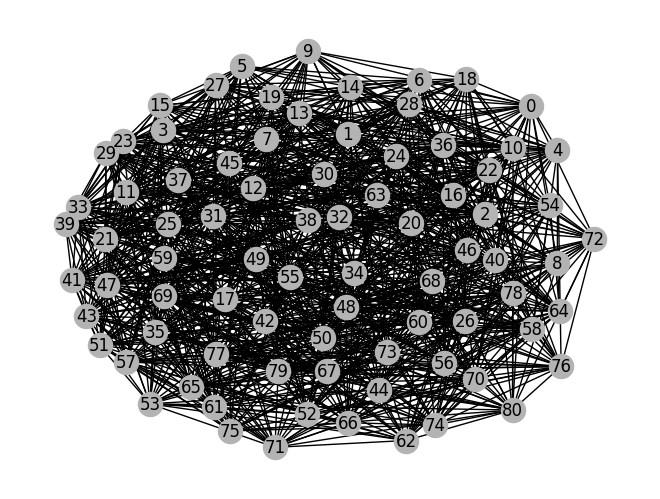

In [30]:
# Visualizzazione grafo
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [31]:
# Creo classe della mia GNN
class GraphSAGE(nn.Module):
    """
    Basic GraphConv-based GNN class object. Constructs the model architecture upon
    initialization. Defines a forward step to include relevant parameters - in this
    case, just dropout.
    """

    def __init__(self, g, in_feats, hidden_size, num_classes, dropout):
        """
        Initialize the model object. Establishes model architecture and relevant hypers (`dropout`, `num_classes`, `agg_type`)

        :param g: Input graph object
        :type g: Data of torch geometric
        :param in_feats: Size (number of nodes) of input layer
        :type in_feats: int
        :param hidden_size: Size of hidden layer
        :type hidden_size: int
        :param num_classes: Size of output layer (one node per class)
        :type num_classes: int
        :param dropout: Dropout fraction, between two convolutional layers
        :type dropout: float
        """

        super(GraphSAGE, self).__init__()
        self.g = g                                        # Grafo in formato data di Torch
        self.conv1 = SAGEConv(in_feats, hidden_size)
        self.relu=nn.ReLU()                               # Funzione di attivazione
        self.dropout = nn.Dropout(p=dropout)              # Dropout
        self.conv2 = SAGEConv(hidden_size, num_classes)

        # Abbiamo un hidden layer con dimensione hidden_size

    def forward(self, g):
        """
        Define forward step of netowrk. In this example, pass inputs through convolution, apply relu
        and dropout, then pass through second convolution.

        :param features: Input node representations
        :type features: torch.tensor
        :return: Final layer representation, pre-activation (i.e. class logits)
        :rtype: torch.tensor"""

        x, edge_index = g.x, g.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

In [32]:
# Trasferimento degli iperparametri per train
dim_embedding = hypers['dim_embedding']
hidden_dim = hypers['hidden_dim']
dropout = hypers['dropout']
number_classes = hypers['number_classes']
agg_type = hypers['layer_agg_type'] or 'mean'
# model=hypers['model']
# print(model)

In [33]:
# Definizione del learning rate
opt_hypers = {
    'lr': hypers.get('learning_rate', None)
}

# Calcolo matrice di adiacenza
adj_ = get_adjacency_matrix(nx_graph, TORCH_DEVICE, TORCH_DTYPE)   # è la stessa per tutti i train del grafo

In [34]:
# Stampa matrice di 0 e 1 dove 0 vuol dire che la coppia di nodi (i, j) non è collegata, 1 vuol dire che è collegata
print(adj_.shape)
print(adj_)

torch.Size([81, 81])
tensor([[0., 1., 1.,  ..., 0., 0., 1.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 1., 0., 1.],
        [1., 0., 0.,  ..., 1., 1., 0.]])


In [35]:
print(nx_graph.edges)

[(0, 10), (0, 20), (0, 30), (0, 40), (0, 50), (0, 60), (0, 70), (0, 80), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 18), (0, 27), (0, 36), (0, 45), (0, 54), (0, 63), (0, 72), (1, 10), (1, 11), (1, 21), (1, 31), (1, 41), (1, 51), (1, 61), (1, 71), (1, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 19), (1, 28), (1, 37), (1, 46), (1, 55), (1, 64), (1, 73), (2, 10), (2, 20), (2, 12), (2, 22), (2, 32), (2, 42), (2, 52), (2, 62), (2, 18), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 11), (2, 29), (2, 38), (2, 47), (2, 56), (2, 65), (2, 74), (3, 30), (3, 13), (3, 23), (3, 33), (3, 43), (3, 53), (3, 11), (3, 19), (3, 27), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 12), (3, 21), (3, 39), (3, 48), (3, 57), (3, 66), (3, 75), (4, 20), (4, 40), (4, 14), (4, 24), (4, 34), (4, 44), (4, 12), (4, 28), (4, 36), (4, 5), (4, 6), (4, 7), (4, 8), (4, 13), (4, 22), (4, 31), (4, 49), (4, 58), (4, 67), (4, 76), (5, 50), (5, 15), (5, 25), (5, 35), (5, 1

In [36]:
print(nx_graph.number_of_edges())

1056


##Passo 3 - Train


### Risultati run dal seed 0 al seed 49 (a scopo esemplificativo)
Il processo é stato in realtá svolto per 150 train di 10000 epoche, sui quali sará calcolato l'errore generalizzato.

Il costo discreto e dunque l'err_train per i 150 train é stato analizzato successivamente.

In [ ]:
# Creo semi da 0 a 49
num_seeds_i = 0
num_seeds_f = 50

number_epochs=hypers['number_epochs']
patience=hypers['patience']
tolerance=hypers['tolerance']

errore_SEEDS=[]

for i in range(num_seeds_i,num_seeds_f):
  seed=i
  print(f'Start training(): Setting seed to {seed}')
  set_seed(seed)

  # Inizializzazione degli input
  embed = nn.Embedding(torchgeom_graph.num_nodes, dim_embedding)    #sto creando matrice  num_nodiXdim_embedding, dove dim_embeddingsono le features iniziali dei nodi
  embed = embed.type(TORCH_DTYPE).to(TORCH_DEVICE)

  data = Data(x=embed.weight, edge_index=torchgeom_graph.edge_index)

  # Inizializzazione dei pesi della rete
  net = GraphSAGE(data, dim_embedding, hidden_dim, number_classes, dropout)

  # Definizione dei parametri di ottimizzazione e dell'ottimizzatore
  params = chain(net.parameters(), embed.parameters())
  optimizer = torch.optim.AdamW(params, **opt_hypers, weight_decay=1e-2)

  # Tracking
  best_cost = torch.tensor(float('Inf'))  #all'inizio +infinito
  best_loss = torch.tensor(float('Inf'))
  best_coloring = None

  # Conteggio della 'patience'
  prev_loss = 1.  # valore iniziale loss (arbitraria)
  cnt = 0


  #metto conto del tempo per ogni train
  t_start = time()

  #creazione di due liste per il plot della loss continua e discreta durante il train
  loss_vector_story=[]
  hard_cost_vector_story=[]

  des_cost=[]


  # Train
  for epoch in range(number_epochs):
      # get soft prob assignments
      logits = net(data)       #rete convoluzionale

      # normalizzo
      probs = F.softmax(logits, dim=1)
      #print(probs.shape)                 #num_nodiXnum_colori (sarebbero le #num_colori=10  probabilitá dei colori per ogni nodo, poi devo prendere quella maggiore)

      #Calcolo il costo continuo con funzione ispirata a modello di Potts
      loss = loss_func_mod(probs, adj_)

      coloring = torch.argmax(probs, dim=1)  #prendo la posizione del massimo della riga e diventa quindi un numero da 0 a num_colori-1 #questo é effettivamente il vettore dei colori di questa epoca

      cost_hard = loss_func_color_hard(coloring, nx_graph)           #calcolo costo discreto

      if cost_hard < best_cost:           #eventuale ridefinizione del miglior costo
          best_loss = loss
          best_cost = cost_hard
          best_coloring = coloring


      # Early stopping check
      if (abs(loss - prev_loss) <= tolerance) | ((loss - prev_loss) > 0):
          cnt += 1
      else:
          cnt = 0

      #Aggiornamento loss
      prev_loss = loss

      loss_vector_story.append(loss.item())
      hard_cost_vector_story.append(cost_hard.item())

      #Controllo 'patience count'
      if cnt >= patience:
          print(f'Stopping early on epoch {epoch}. Patience count: {cnt}')
          break

      # optimization con backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  des_cost.append(best_cost.item())

  # Print final loss
  print('\t Epoch %d | Final loss: %.5f' % (epoch, loss.item()))
  print('\t Epoch %d | Lowest discrete cost: %.2f  ' % (epoch, best_cost))

  # Final coloring
  final_loss = loss
  final_coloring = torch.argmax(probs, 1)

  #conto finale del tempo
  runtime_gnn = round(time() - t_start, 4)
  print(f'\t GNN runtime: {runtime_gnn}s')

  #calcolo errore per ogni seme diverso, cioe per ogni train
  errore=err_train(best_cost,torchgeom_graph.edge_index.shape[1])
  print('Errore per seme=%d = %.6f' % (seed,np.array(errore)))

  errore_SEEDS.append(errore)

errore_medio=np.mean(np.array(errore_SEEDS))   #errore generalizzato
print('errore medio con %d semi/training inizializzati diversamente = %.6f' % (num_seeds_f - num_seeds_i, errore_medio))



Start training(): Setting seed to 0
	 Epoch 9999 | Final loss: 11.99999
	 Epoch 9999 | Lowest discrete cost: 9.00  
	 GNN runtime: 376.4025s
Errore per seme=0 = 0.008523
Start training(): Setting seed to 1
	 Epoch 9999 | Final loss: 27.01258
	 Epoch 9999 | Lowest discrete cost: 11.00  
	 GNN runtime: 358.4692s
Errore per seme=1 = 0.010417
Start training(): Setting seed to 2
	 Epoch 9999 | Final loss: 6.00000
	 Epoch 9999 | Lowest discrete cost: 6.00  
	 GNN runtime: 360.6399s
Errore per seme=2 = 0.005682
Start training(): Setting seed to 3
	 Epoch 9999 | Final loss: 11.00000
	 Epoch 9999 | Lowest discrete cost: 11.00  
	 GNN runtime: 359.2129s
Errore per seme=3 = 0.010417
Start training(): Setting seed to 4
	 Epoch 9999 | Final loss: 21.01054
	 Epoch 9999 | Lowest discrete cost: 9.00  
	 GNN runtime: 359.9698s
Errore per seme=4 = 0.008523
Start training(): Setting seed to 5
	 Epoch 9999 | Final loss: 4.00020
	 Epoch 9999 | Lowest discrete cost: 3.00  
	 GNN runtime: 359.418s
Errore per

## Passo 4 - Risultati


### Risultati run
Viene riportato il vettore completo dei costi discreti

In [41]:
#  Vettore di tutti i costi discreti ottenuti dalle 150 run
des_cost= [12, 12, 7, 11, 7, 14, 9, 8, 12, 10, 13, 11, 13, 10, 11, 12, 10, 11, 9, 8, 11, 10, 12, 10, 9, 11, 12, 12, 9, 9, 9, 10, 8, 12, 8, 10, 9, 11, 10, 12, 9, 9, 12, 9, 10, 12, 13, 14, 9, 10, 9, 11, 6, 11, 9, 12, 9, 12, 9, 10, 10, 9, 14, 7, 9, 16, 7, 9, 7, 10, 13, 12, 9, 11, 8, 12, 9, 10, 5, 9, 10, 7, 9, 13, 12, 11, 19, 9, 8, 12, 9, 9, 12, 9, 10, 13, 9, 15, 6, 7, 16, 9, 8, 15, 10, 9, 9, 10, 14, 10, 12, 10, 10, 9, 9, 8, 10, 11, 10, 14, 7, 12, 14, 8, 12, 10, 7, 10, 10, 8, 10, 9, 9, 11, 8, 8, 11, 12, 8, 9, 10, 8, 15] # il 19 in realtà è un 18


###Occorrenze dei costi discreti e legame con l'energia
Istogramma dei costi discreti(cioé link sbagliati) dopo 10000 epoche per i 150 train effettuati.

I valori piú frequenti corrispondono a buche energetiche piú attrattive. Infatti in questo modello una perfetta colorazione corrisponde a energia 0 e l'energia é definita come costo discreto/num link.

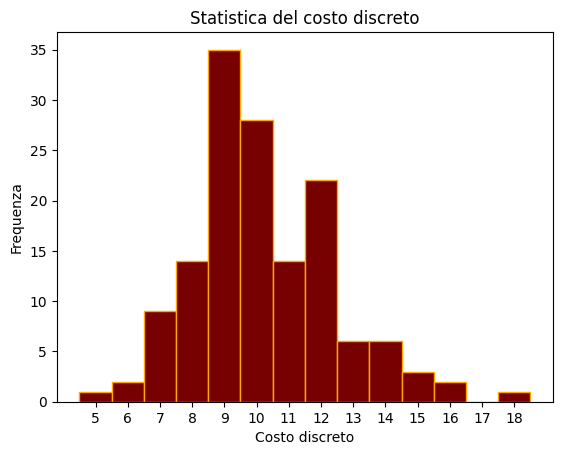

In [42]:
import matplotlib.pyplot as plt
# Creazione dell'istogramma
plt.hist(des_cost, bins=14, color='#770000', edgecolor='orange', align = 'mid')
plt.title('Statistica del costo discreto')
plt.xlabel('Costo discreto')
plt.ylabel('Frequenza')

ticks = np.arange(5.5, 19.5, 1)
label = np.arange(5, 19, 1)
plt.xticks(ticks, label)

# Visualizzazione
plt.show()


###Plot errore sul train e errore generalizzato

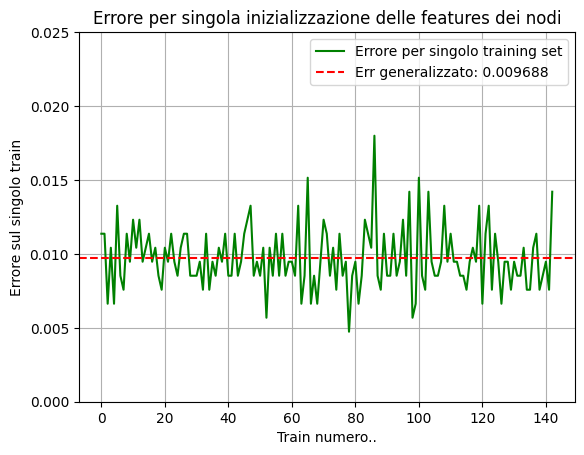

In [63]:
import matplotlib.pyplot as plt

errore_SEEDS=np.array(des_cost)/(torchgeom_graph.edge_index.shape[1]*0.5)    #vettore degli errori di singolo train
errore_gen=np.mean(errore_SEEDS)  #media degli errori


plt.plot(range((errore_SEEDS.shape[0])), errore_SEEDS, label='Errore per singolo training set', color='green')
plt.axhline(y=errore_medio, color='red', linestyle='--', label='Err generalizzato: {:.6f}'.format(errore_medio))
plt.title('Errore per singola inizializzazione delle features dei nodi')
plt.xlabel('Train numero..')
plt.ylabel('Errore sul singolo train')
plt.ylim(0,0.025)
plt.legend()
plt.grid()
plt.show()

##Passo 5 - Commenti


###Loss continua e discreta durante l'addestramento per l'ultimo train

Andamento della loss continua e discreta per le 10000 epoche di un train (sopra) e zoom alle prime 500 epoche (sotto).

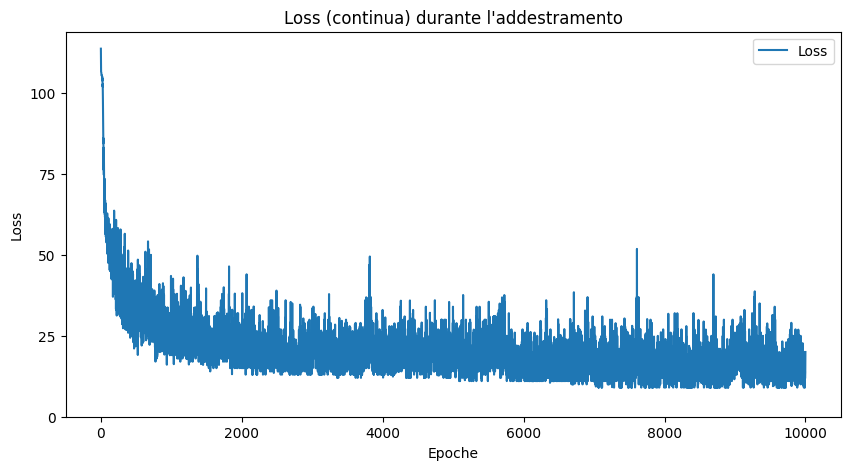

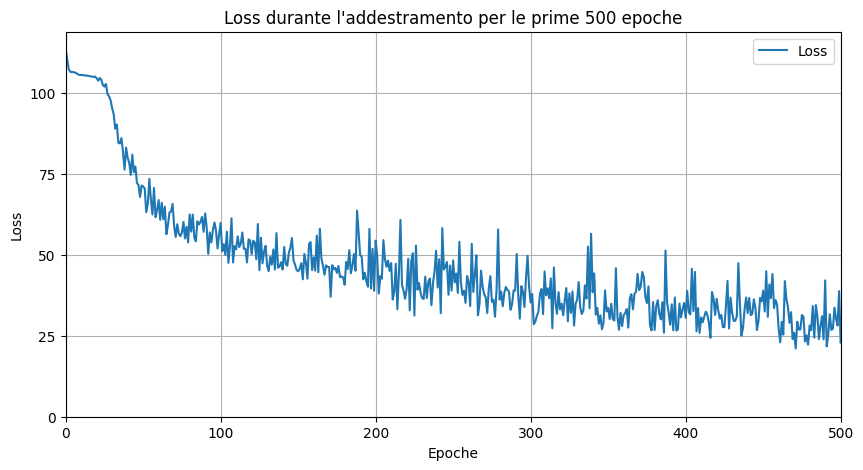

In [64]:
loss_vector_story_array=np.array(loss_vector_story)
hard_cost_vector_story_array= np.array(hard_cost_vector_story)

# Traccio il grafico della loss CONTINUA
from matplotlib import pyplot as plt
import math

plt.figure(figsize=(10, 5))
plt.plot(range((loss_vector_story_array.shape[0])), loss_vector_story_array, label='Loss')
plt.title('Loss (continua) durante l\'addestramento')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.yticks(range(0, math.floor(max(loss_vector_story)) + 1, 25))
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range((loss_vector_story_array.shape[0])), loss_vector_story_array, label='Loss')
plt.title('Loss durante l\'addestramento per le prime 500 epoche')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.xlim(0,500)
plt.yticks(range(0, math.floor(max(loss_vector_story)) + 1, 25))              #prendo il massimo di questa lista(loss_vector_story) e lo rendo un numero
plt.legend()
plt.grid()
plt.show()

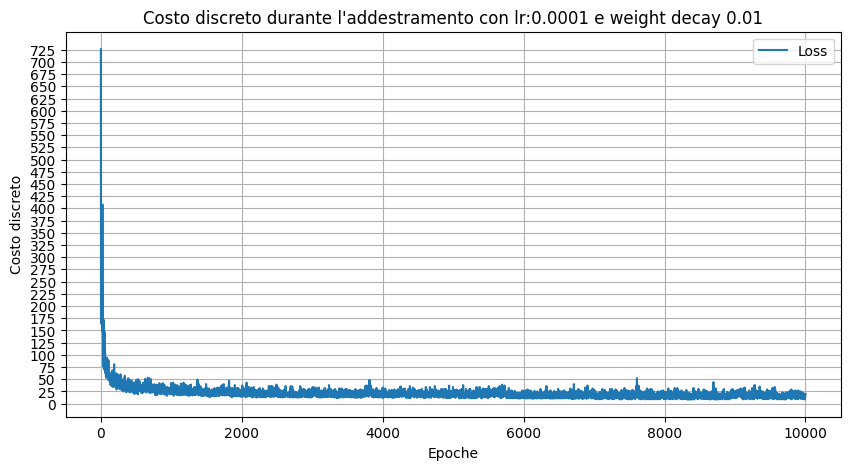

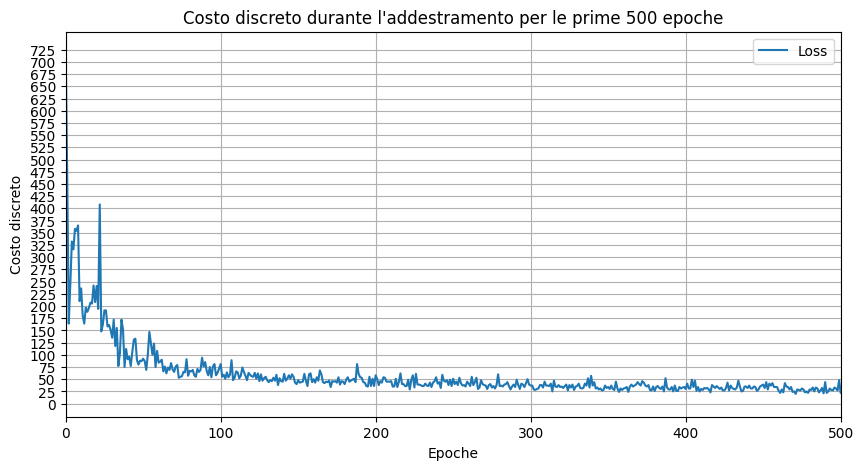

In [65]:
#COSTO DISCRETO plot su un train da 10000 epoche

from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range((hard_cost_vector_story_array.shape[0])), hard_cost_vector_story, label='Loss')
plt.title('Costo discreto durante l\'addestramento con lr:0.0001 e weight decay 0.01')
plt.xlabel('Epoche')
plt.ylabel('Costo discreto')
plt.yticks(range(0, max(hard_cost_vector_story) + 10, 25))
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range((hard_cost_vector_story_array.shape[0])), hard_cost_vector_story, label='Loss')
plt.title('Costo discreto durante l\'addestramento per le prime 500 epoche')
plt.xlabel('Epoche')
plt.ylabel('Costo discreto')
plt.yticks(range(0, max(hard_cost_vector_story) + 10, 25))
plt.xlim(0,500)
plt.legend()
plt.grid()
plt.show()

###Grafo colorato
Colorazione risultante dall'ultimo train

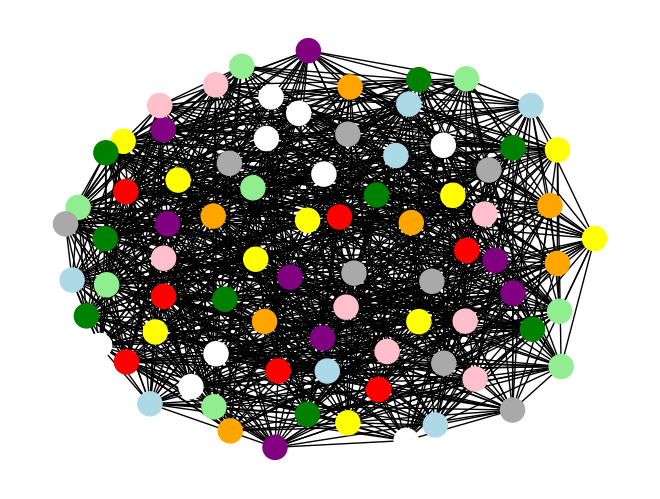

In [66]:
# Visualizzo
color_dict = {
    0: 'orange',
    1: 'lightblue',
    2: 'purple',
    3: 'red',
    4: 'lightgreen',
    5: 'green',
    6: 'yellow',
    7: 'pink',
    8: 'white',
    9: 'darkgrey',
    10: 'blue',
    11: 'cyan',
    12: 'magenta'                 #metto piú di 10 colori, tanto poi non me li considera
}
color_map = np.vectorize(color_dict.get)(best_coloring.cpu())
nx.draw(nx_graph, pos, with_labels=False, node_color=color_map)

Stesso plot ma evidenziando i link sbagliati

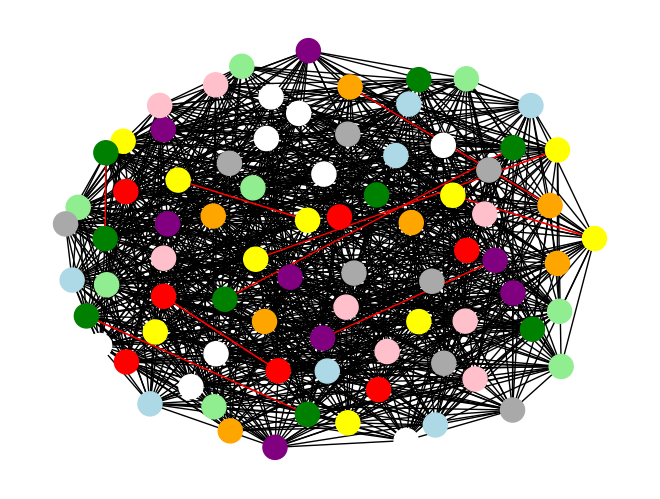

In [67]:
edge_color_map = ['red' if best_coloring[u] == best_coloring[v] else 'black' for u, v in nx_graph.edges()]

wrong_edges=[(u, v) for u, v in nx_graph.edges() if best_coloring[u] == best_coloring[v]]  # Archi rossi=archi sbagliati

nx.draw(nx_graph, pos, with_labels=False, node_color=color_map,edge_color=edge_color_map)
nx.draw_networkx_edges(nx_graph, pos, edgelist=wrong_edges, edge_color='red')

# Problema 2 - Myciel6

Su questa tipologia di grafo e sul queen8_8 é stata svolta un'analisi diversa dell'errore generalizzato.

Lo scopo di questa sezione é vedere come varia la performance della rete quando il problema diventa piú complesso con l'aumento del numero di link.

I grafi prodotti con questo codice sono stati analizzati con un codice analogo al precendente(10000 epoche per ogni train, rispettivamente 50 train e 30 train per queen8_8 e myciel6 per ogni grafo)

##Passo 1 - Set iperparameters - Impostazione del problema Myciel6

In [68]:
# Specify the problem instance to solve and where to find the dataset(s) here:

problem_file = 'myciel6.col'

save_errore_path = '1500link_NEW_30semi_myciel6_errore.pth'    #salvo errore in questo file (errore di train su varie inizializzazioni(30 qui) per grafo con 1500 link aggiunti)

input_parent = './data/input/COLOR/instances'

In [71]:
# Definizione iperparametri
hypers = {
        'model': 'SAGEConv',   #Useró solo SAGEConv come layer convoluzionale
        'dim_embedding': 8,    #numero di features iniziali associate ad ogni nodo
        'dropout': 0.2225,
        'learning_rate':    0.01779,
        'hidden_dim': 22,      #dimensione del layer nascosto(in questo algoritmo un solo hidden layer-> vedi class GraphSAGE)
        'seed': SEED_VALUE ,
        'num_seeds':30      #numero di inizializzazioni dell'input e dei pesi della rete
    }


# Def. iperparametri per il train
solver_hypers = {
    'tolerance': 1e-3 ,          # Se la loss non cambia piú della tolleranza, aggiungo +1 al conto di 'patience'
    'number_epochs': int(1e4),   # Numero massimo di epoche =10000
    'patience': 500,             # Numero di volte di seguito nel quale la loss non cambia necessari per arrestare il run prematuramente #Number early stopping triggers before breaking loop
    'graph_file': problem_file,  # Problema che si sta risolvendo (nome del grafo)
    'layer_agg_type': 'mean',    # Come aggregare i vicini samplati con GraphSAGE
    'number_classes': chromatic_numbers[problem_file]      #numero di colori da usare per colorare il grafo
}


hypers.update(solver_hypers)

In [72]:
input_fpath = os.path.join(input_parent, problem_file)

nx_graph = build_graph_from_color_file(input_fpath, node_offset=-1, parent_fpath='')

torchgeom_graph = from_networkx(nx_graph)
torchgeom_graph = torchgeom_graph.to(TORCH_DEVICE)

Building graph from contents of file: ./data/input/COLOR/instances/myciel6.col


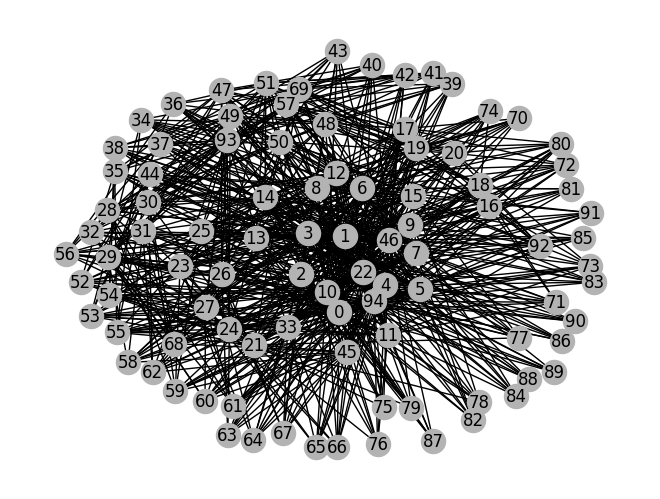

In [73]:
# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

##Passo 2 - Caricamento grafo colorato di partenza

Qui si usa una delle possibili colorazioni esatte, trovata con un train come nell'esempio precedente.

In [74]:
best_coloring=torch.tensor([4, 3, 1, 3, 4, 4, 2, 2, 2, 2, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 5, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 6, 6, 6, 6, 0, 0, 0, 6, 0, 6, 0, 3, 2])   #qua gli do una lista e la faccio diventare torch tensor

best_coloring = best_coloring.to(TORCH_DEVICE)

print(best_coloring)
#vettore coi colori esatti (0% errore sul train)

tensor([4, 3, 1, 3, 4, 4, 2, 2, 2, 2, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 5, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 6, 6, 6, 6, 0, 0, 0, 6, 0, 6, 0, 3, 2])


In [75]:
#prova che effettivamente fa 0 errori, quindi uso funz loss_func_color_hard
cost_hard = loss_func_color_hard(best_coloring, nx_graph)  #costo discreto
print(f'link sbagliati per il best_coloring={cost_hard}    \t| Attenzione, deve venire 0')

link sbagliati per il best_coloring=0    	| Attenzione, deve venire 0


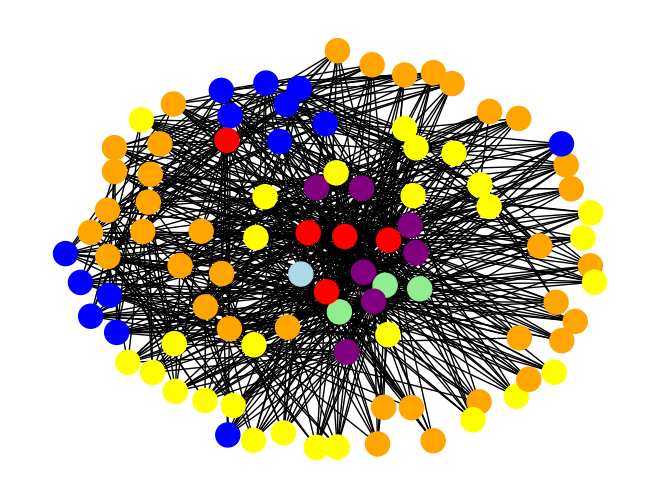

In [76]:
# Visualizzo colorazione esatta che ho trovato con vecchio script
color_dict = {0:'orange', 1:'lightblue', 2:'purple', 3:'red', 4:'lightgreen',5:'blue',6:'yellow'}   #7 colori
color_map = np.vectorize(color_dict.get)(best_coloring.cpu())
nx.draw(nx_graph, pos, with_labels=False, node_color=color_map)

##Passo 3 - Tolgo e aggiungo link

###Tolgo link



In [80]:
#prendo spunto da loss func color hard per aumentare e diminuire link
def diminuisci_link_e_errore(coloring, nx_graph):
    """
    Function to compute cost value based on color vector (0, 2, 1, 4, 1, ...)

    :param coloring: Vector of class assignments (colors)
    :type coloring: torch.tensor
    :param nx_graph: Graph to evaluate classifications on
    :type nx_graph: networkx.OrderedGraph  --> da me cambiato con DiGraph
    :return: Cost of provided class assignments
    :rtype: torch.tensor
    """

    cost_ = 0
    for (u, v) in nx_graph.edges:
        cost_ += 1*(coloring[u] == coloring[v])*(u != v)     #1 if the two nodes have the same color and are not the same node

    if cost_==0:               # Controlla che ci siano archi da rimuovere e mette tutti i possibili archi in una lista chiamata edges
        edges = list(nx_graph.edges())
        # Seleziona un arco a caso
        edge_to_remove = random.choice(edges)             #sceglie random una da edges

        # Rimuovi l'arco
        nx_graph.remove_edge(*edge_to_remove)             #rimuove edge scelta a caso sopra

        #print(f"Rimosso l'arco: {edge_to_remove}")   #scommentare per piu info

    #print('#link rimasti=',nx_graph.number_of_edges())     #scommentare per piu info


    return nx_graph,cost_

In [82]:
#scommentare per ricreare grafo iniziale
#nx_graph = build_graph_from_color_file(input_fpath, node_offset=-1, parent_fpath='')

Building graph from contents of file: ./data/input/COLOR/instances/myciel6.col


In [83]:
#tolgo link
number_epochs=nx_graph.number_of_edges()
old_costo=0
costo_story=[]
nx_graph_new=nx_graph

for i in range(number_epochs):
  if old_costo==0:
    nx_graph_new,hard_cost_attuale=diminuisci_link_e_errore(best_coloring, nx_graph_new)
    old_costo=hard_cost_attuale
  else:
    print('Errore diverso da 0')
  costo_story.append(old_costo)


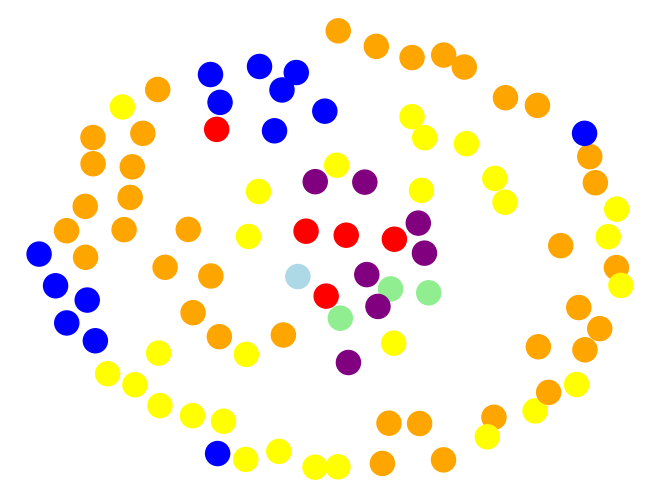

In [84]:
#mostro che ha funzionato mostrando il grafo ora, senza link
nx.draw(nx_graph_new, pos, with_labels=False, node_color=color_map)

###Aggiunta link
Ripartendo dal grafo iniziale(755 link) per generare grafi che rispettano la stessa colorazione ma con piu link.
Ogni 500 link in piú salvo il grafo.

In [120]:
nx_graph = build_graph_from_color_file(input_fpath, node_offset=-1, parent_fpath='')

Building graph from contents of file: ./data/input/COLOR/instances/myciel6.col


In [117]:
from itertools import combinations
import sys
all_possible_edges = set(combinations(nx_graph.nodes, 2))  # Tutte le combinazioni di nodi

In [119]:
#prendo spunto da loss func color hard per aumentare e diminuire link
def aggiungi_link(coloring, nx_graph,cost_,all_possible_edges):
    """
    Function to compute cost value based on color vector (0, 2, 1, 4, 1, ...)

    :param coloring: Vector of class assignments (colors)
    :type coloring: torch.tensor
    :param nx_graph: Graph to evaluate classifications on
    :type nx_graph: networkx.OrderedGraph  --> da me cambiato con DiGraph
    :return: Cost of provided class assignments
    :rtype: torch.tensor
    """

    if cost_==0:
        existing_edges = set(nx_graph.edges())       #tutti i possibili
        missing_edges = all_possible_edges - existing_edges         #i mancanti(cioé i possibili esclusi i giá preenti)
        edges=[]

        for(h,k) in missing_edges:
          if ((coloring[h] != coloring[k])*(h != k))==1:      #condizione di NON collegare colori uguali (1 se due nodi diversi(h e k) sono di colore diverso)
            edges.append((h,k))                      # Seleziona un arco a caso fra tutti i mancanti che NON che collega colori uguali
        try:
          edge_to_add = random.choice(edges)
        except IndexError:
          print("Errore: La lista 'edges mancanti corrette' è vuota, cioé non posso aggiungere altri link che rendono grafo ancora colorato")   #mi avverte che ho finito le mancanti corrette, da qua in poi la soluzione best_coloring non andrá piu bene e basta
          return 0
        # Aggiugi l'arco
        nx_graph.add_edge(*edge_to_add)

        #print(f"Aggiunto l'arco: {edge_to_add}")

    # Stampa gli archi dopo l'AGGIUNTA
    #print("Archi dopo aggiunta:", nx_graph.edges())
    #print(f'Costo prima l\'aggiunta:{cost_}')
    #print('Num archi ora:',nx_graph.number_of_edges())

    return nx_graph

In [121]:
#creo grafo con 1000 link in piu
number_epochs=3000               #nx_graph.number_of_edges()
old_costo=0
costo_story=[]
nx_graph_new=nx_graph

for i in range(number_epochs+1):
    nx_graph_new=aggiungi_link(best_coloring, nx_graph_new,old_costo,all_possible_edges)
    if nx_graph_new == 0:
      break
    costo=loss_func_color_hard(best_coloring, nx_graph_new)
    old_costo=costo

    #if (i%500)==0:    (eventualmente scommentare per salvare nuovo grafo in un file ogni 500 aggiunte, ma il file giá é stato creato)
      # Salvare il grafo in formato GraphML

      #filename = f"grafo_{i}_NEW.gml"
      #nx.write_graphml(nx_graph_new, filename)
      #print(f'sto salvando grafo ad aggiunta{i}, cioé all\'i-esimo link aggiunto')

    if costo!=0:
      print('Errore diverso da 0')

    costo_story.append(costo)

print('somma errori totali:', sum(costo_story))
#len(costo_story)

Errore: La lista 'edges mancanti corrette' è vuota, cioé non posso aggiungere altri link che rendono grafo ancora colorato
somma errori totali: tensor(0)


2541

Ad un certo punto(iterazione 2541) non é piu possibile aggiungere link perché l'insieme di link concessi affinché il grafo resti colorato é vuoto.

In [122]:
print('somma degli errori=',sum(costo_story),'\t|DEVE VENIRE 0')
print('num link aggiunti a grafo iniziale(755 link)= ',len(costo_story))   #quindi qua link totali =

somma degli errori= tensor(0) 	|DEVE VENIRE 0
num link aggiunti a grafo iniziale(755 link)=  2541


In [123]:
#cerco di confermare che nell'ultimo grafo costruibile con questo best_coloring ho 3928 link e lo salvo come ultimo creabile
print(nx_graph_new,'\t giusto, stessi nodi ma num_edges=755+2541=3296')

# Salvare il grafo in formato GraphML
#filename = f"grafo_3296_NEW.gml"
#nx.write_graphml(nx_graph_new, filename)
#print(f'sto salvando grafo ad ultima aggiunta {i}, cioé all\'i-esimo link aggiunto')

0 	 giusto, stessi nodi ma num_edges=755+2541=3296


In [124]:
ls

1000link_NEW_30semi_myciel6_errore.pth  grafo_500_NEW.gml
1500link_NEW_30semi_myciel6_errore.pth  instances.tar
500link_NEW_30semi_myciel6_errore.pth   Myciel6_1000link.pth
data/                                   __pycache__/
gc_example.ipynb                        requirements.txt
gc_example_prova1.ipynb                 SAGE_best_model_coloring_11X11.pth
GCN_best_model_coloring_5X5.pth         SAGE_best_model_coloring_13X13.pth
grafo_0.gml                             SAGE_best_model_coloring_5X5.pth
grafo_0_NEW.gml                         SAGE_best_model_coloring_6X6.pth
grafo_1000.gml                          SAGE_best_model_coloring_7X7
grafo_1000_NEW.gml                      SAGE_best_model_coloring_7X7.pth
grafo_1500_NEW.gml                      SAGE_best_model_coloring_8X12.pth
grafo_2000.gml                          SAGE_best_model_coloring_9X9.pth
grafo_2000_NEW.gml                      SAGE_best_model_coloring_anna.pth
grafo_2500_NEW.gml                      SAGE_best_model_co

In [125]:
nx_graph_0_755 = nx.read_graphml("grafo_0_NEW.gml")
nx_graph_500_755 = nx.read_graphml("grafo_500_NEW.gml")
nx_graph_1000_755 = nx.read_graphml("grafo_1000_NEW.gml")
nx_graph_2000_755 = nx.read_graphml("grafo_2000_NEW.gml")
nx_graph_3296 =nx.read_graphml("grafo_3296_NEW.gml")

Text(0.5, 1.0, 'Grafo 3296, 755+2541 link')

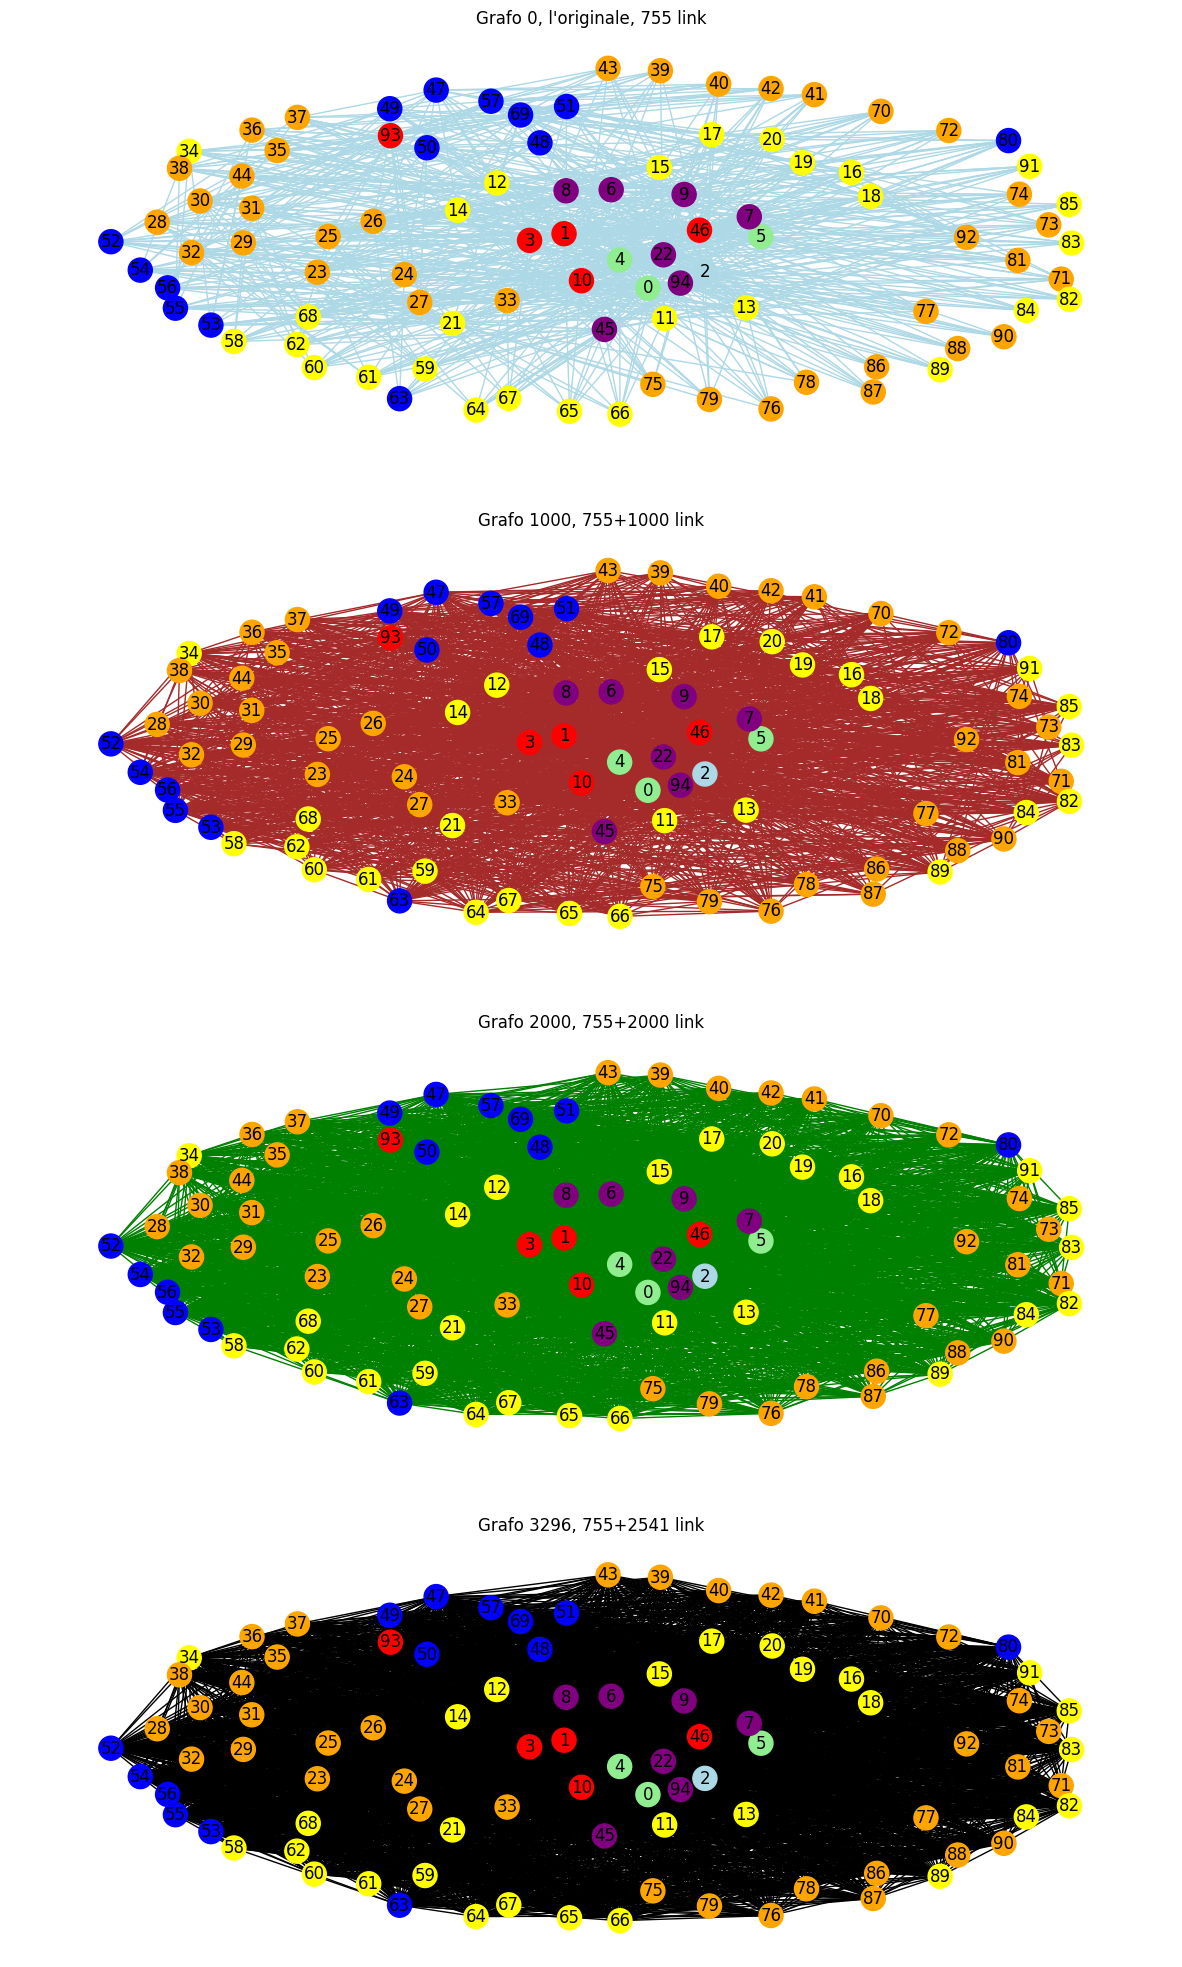

In [127]:
# Visualize
import matplotlib.pyplot as plt

pos_0 = nx.kamada_kawai_layout(nx_graph_0_755)

#figura con 1 riga e 3 colonne
fig, axs = plt.subplots(4, 1, figsize=(15, 25))

nx.draw(nx_graph_0_755, pos_0, with_labels=True, node_color=color_map, ax=axs[0], edge_color='lightblue')
axs[0].set_title("Grafo 0, l'originale, 755 link")

nx.draw(nx_graph_1000_755, pos_0, with_labels=True, node_color=color_map, ax=axs[1], edge_color='brown')
axs[1].set_title("Grafo 1000, 755+1000 link")

nx.draw(nx_graph_2000_755, pos_0, with_labels=True, node_color=color_map, ax=axs[2], edge_color='green')
axs[2].set_title("Grafo 2000, 755+2000 link")

nx.draw(nx_graph_3296, pos_0, with_labels=True, node_color=color_map, ax=axs[3], edge_color='black')
axs[3].set_title("Grafo 3296, 755+2541 link")

Ora che si é costruito un grafo con piu link di cui si ha gia la soluzione(quindi esiste)
si deve rifare il train con questo grafo qui con 500,1000,2000,3000 link in piu e vedere se si colora

Come caricare file grafo generato per colorarlo:

In [129]:
nx_grafo_vecchio = build_graph_from_color_file(input_fpath, node_offset=-1, parent_fpath='')
nx_graph_500 = nx.read_graphml("grafo_500_NEW.gml")          #nx_graph di prima+500 link
nx_graph_1000= nx.read_graphml("grafo_1000_NEW.gml")
nx_graph_1500= nx.read_graphml("grafo_1500_NEW.gml")

#ORA CARICO nx_graph di prima ma con 1500 link in piu prendendolo da file generato sopra
nx_graph = nx_graph_1500
nx_graph = nx.convert_node_labels_to_integers(nx_graph)    #questo é NECESSARIO perché mi converte la lista di stringhe in interi

torchgeom_graph = from_networkx(nx_graph)
torchgeom_graph = torchgeom_graph.to(TORCH_DEVICE)

Building graph from contents of file: ./data/input/COLOR/instances/myciel6.col


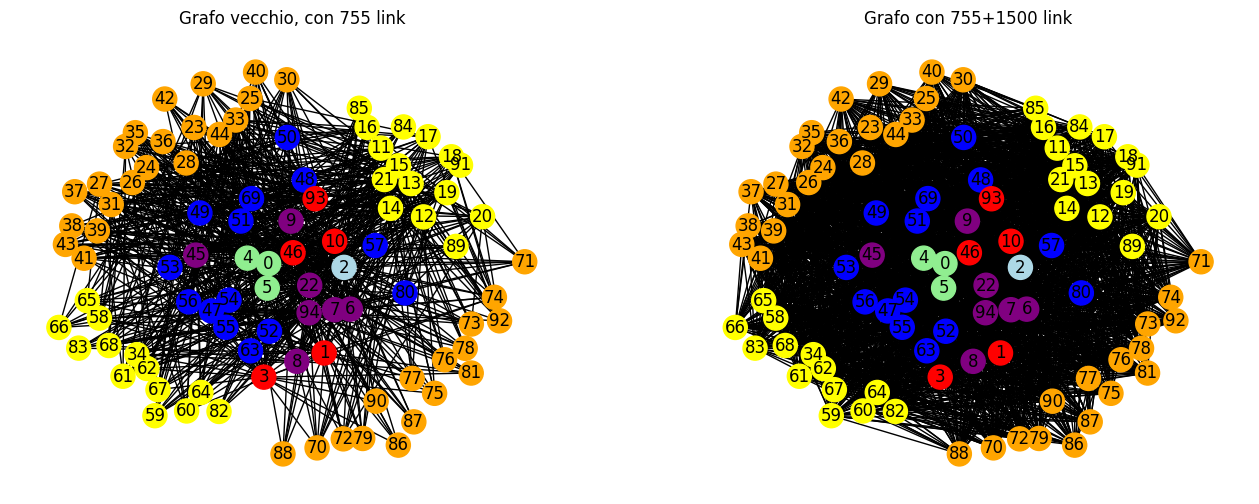

In [131]:
import matplotlib.pyplot as plt

#visualizzo grafo appena creato (a destra) e grafo originale (a sinistra)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # 1 riga, 2 colonne

pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_grafo_vecchio, pos, ax=ax[0], with_labels=True, node_color=color_map)
ax[0].set_title("Grafo vecchio, con 755 link")

nx.draw(nx_graph, pos, ax=ax[1], with_labels=True, node_color=color_map)
ax[1].set_title("Grafo con 755+1500 link")

plt.show()